In [39]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import emlearn

## Load data

In [40]:
DATA_PATH = Path('train_set')

label_activity_map = {}
samples_map: dict[str, list[pd.DataFrame]] = {}
for activity_class_path in DATA_PATH.iterdir():
    activity_class = activity_class_path.stem
    class_samples = []
    for sample_file_path in activity_class_path.glob("*.txt"):
        sample_df = pd.read_csv(sample_file_path, sep="\t")
        sample_df["LABEL"] = activity_class
        class_samples.append(sample_df)
    samples_map[activity_class] = class_samples

print(samples_map.keys())
samples_map

dict_keys(['cycling', 'walking', 'stationary', 'running'])


{'cycling': [       A_X [mg]   A_Y [mg]    A_Z [mg]  G_X [dps]  G_Y [dps]  G_Z [dps]  \
  0    -532.88400  318.54900   800.12800   1.802634  -4.855078   2.753017   
  1    -545.93270  306.41083   774.30820   0.448732  -3.686064   1.734838   
  2    -539.57880  319.38440   775.63740   0.008653  -2.680702   1.575050   
  3    -552.30475  303.36084   742.64910   1.477986  -3.081899   1.915423   
  4    -544.12060  297.28333   738.11786   1.501972  -3.639454   2.821070   
  ...         ...        ...         ...        ...        ...        ...   
  6235 -309.53860  663.07660  1037.66210  -2.564757   9.977586  10.268719   
  6236 -448.40780  631.11890   907.92290 -12.675225  10.641989  12.704135   
  6237 -440.88880  383.20285   684.07870 -20.404827  14.186328   6.076445   
  6238 -420.07248  345.89163   685.81006 -15.245555   9.438767   5.084689   
  6239 -497.90646  380.30730   819.06464 -12.288746  10.923522   6.387589   
  
          LABEL  
  0     cycling  
  1     cycling  
  2     

## Build features 

### Rolling average

In [41]:
WINDOW_SIZE = 100

feature_df_list = []
for sample_df_list in samples_map.values():
    for sample_df in sample_df_list:
        sample_label = sample_df.pop("LABEL")
        sample_feature_df = (
            sample_df
            .rolling(window=WINDOW_SIZE, step=WINDOW_SIZE)
            .mean()
            .dropna(axis="index", how="all")
        )
        sample_feature_df["LABEL"] = sample_label
        feature_df_list.append(sample_feature_df)
feature_df = pd.concat(feature_df_list).convert_dtypes()

Y = feature_df.pop("LABEL").to_numpy()
print(Y.shape)
X = feature_df.to_numpy()
print(X.shape)

(2512,)
(2512, 6)


In [42]:
Y

array(['cycling', 'cycling', 'cycling', ..., 'running', 'running',
       'running'], dtype=object)

In [43]:
X

array([[-528.6030524, 339.78507602700006, 765.7027834999999,
        7.626247044615, 2.4277054244, -4.05237624537],
       [-473.42035232, 540.4240885, 706.0217339, 20.2709765186,
        20.0769606153, 3.7880261820000003],
       [-406.77261285000003, 600.1303016, 677.1728023000001,
        -61.501799137, -9.428375171, 21.992673534],
       ...,
       [-535.9518085679999, 1131.5968387599999, -44.396182527,
        26.1052801516, 2.0412561150000013, -16.75354283],
       [-561.36448276, 996.505024107, 58.851915318, 25.752352956,
        11.0708532325, 0.770632409399999],
       [-809.9207173446999, 1387.5032120499998, -56.084913486000005,
        11.038008615599999, 31.496495836999998, 40.787075247999994]],
      dtype=object)

## Formatting data for the model

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2009, 6)
(2009,)
(503, 6)
(503,)


In [45]:
pd.Series(Y_test).value_counts()

running       127
walking       127
stationary    126
cycling       123
Name: count, dtype: int64

## Model training

### Manual parameter selection

In [46]:
classifier = DecisionTreeClassifier()

In [47]:
classifier.fit(X_train, Y_train)
classifier

DecisionTreeClassifier()

In [48]:
Y_pred = classifier.predict(X_test)
Y_pred

array(['running', 'cycling', 'stationary', 'walking', 'cycling',
       'walking', 'running', 'walking', 'walking', 'cycling',
       'stationary', 'stationary', 'cycling', 'cycling', 'running',
       'walking', 'walking', 'walking', 'running', 'walking', 'walking',
       'cycling', 'walking', 'running', 'stationary', 'walking',
       'running', 'stationary', 'cycling', 'stationary', 'walking',
       'cycling', 'cycling', 'running', 'running', 'stationary',
       'walking', 'running', 'cycling', 'running', 'cycling', 'walking',
       'running', 'walking', 'running', 'walking', 'walking', 'walking',
       'running', 'walking', 'stationary', 'cycling', 'walking',
       'running', 'cycling', 'running', 'walking', 'stationary',
       'walking', 'running', 'walking', 'cycling', 'stationary',
       'running', 'stationary', 'walking', 'stationary', 'cycling',
       'running', 'running', 'cycling', 'stationary', 'cycling',
       'cycling', 'walking', 'running', 'cycling', 'walking'

In [49]:
(Y_pred == Y_test).mean()

0.9165009940357853

In [50]:
cmodel = emlearn.convert(classifier, method="inline")
cmodel

In [51]:
# _ = cmodel.save(name="activity_classifier", file="activity.h")

### Hyperparameter search

In [52]:
GRID_SEARCH_PARAMETERS = {
    "criterion": ('gini', 'entropy', 'log_loss'),
    "max_depth": (3, 4, 5, 6, 7),
    "min_samples_leaf": np.floor(10**np.linspace(1.5, 3, num=10)).astype("int"),
}
GRID_SEARCH_PARAMETERS

{'criterion': ('gini', 'entropy', 'log_loss'),
 'max_depth': (3, 4, 5, 6, 7),
 'min_samples_leaf': array([  31,   46,   68,  100,  146,  215,  316,  464,  681, 1000])}

In [53]:
def hyperp_search(x, y, classifier, parameters: dict[str, list]):
    gs = GridSearchCV(
        classifier,
        parameters,
        cv=10,
        scoring="f1_micro",
        verbose=0,
        n_jobs=4,
    )
    gs = gs.fit(x, y)
    return gs.best_estimator_

In [54]:
grid_search_classifier = hyperp_search(
    X_train,
    Y_train,
    DecisionTreeClassifier(),
    GRID_SEARCH_PARAMETERS,
)
grid_search_classifier

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=31)

In [55]:
grid_search_classifier.classes_

array(['cycling', 'running', 'stationary', 'walking'], dtype=object)

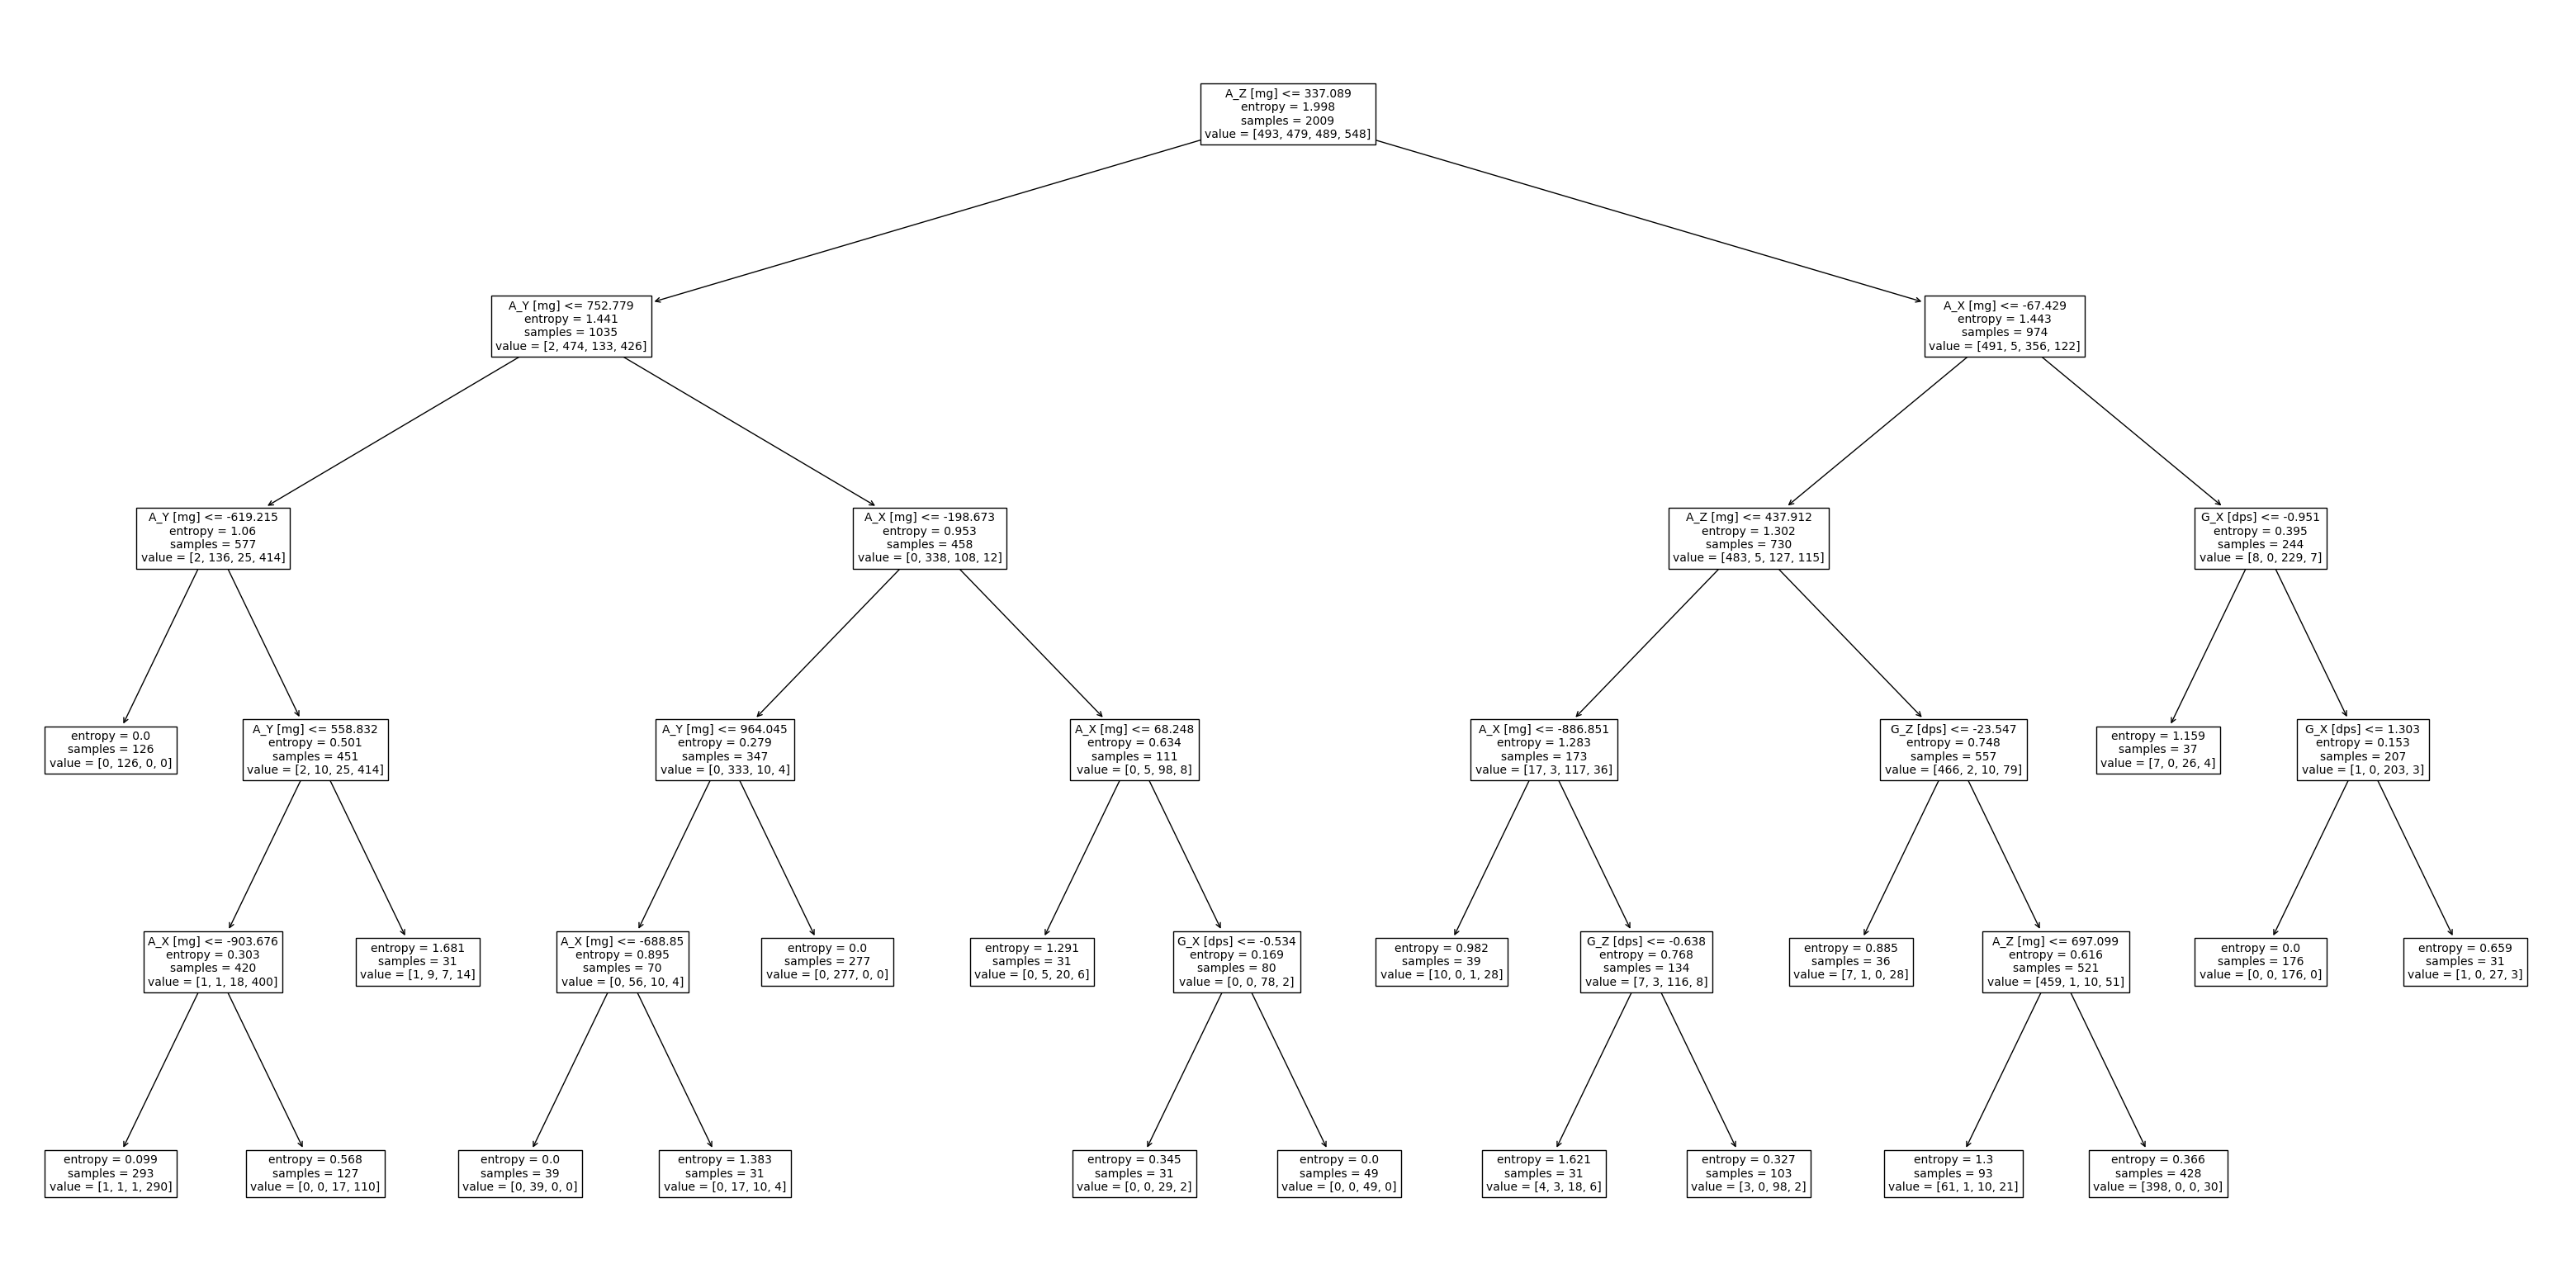

In [56]:
fig, ax = plt.subplots(figsize=(40, 20))
plot_tree(
    grid_search_classifier,
    feature_names=feature_df.columns,
    max_depth=None,
    fontsize=10,
    ax=ax,
)
fig.savefig("foo.svg")

In [57]:
Y_pred_grid_search = grid_search_classifier.predict(X_test)
(Y_pred_grid_search == Y_test).mean()

0.9025844930417495

In [58]:
cmodel = emlearn.convert(grid_search_classifier, method="inline")
_ = cmodel.save(name="activity_classifier", file="activity.h")

### Dimensionality reduction

In [22]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, Y_train)
lda

LinearDiscriminantAnalysis(n_components=2)

<Axes: >

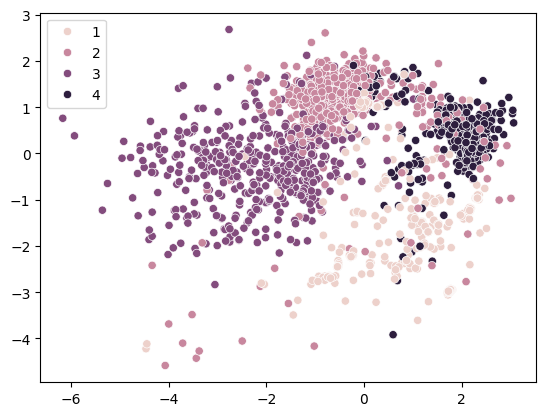

In [23]:
sns.scatterplot(
    x=X_train_lda[:, 0],
    y=X_train_lda[:, 1],
    hue=Y_train,
)

<Axes: >

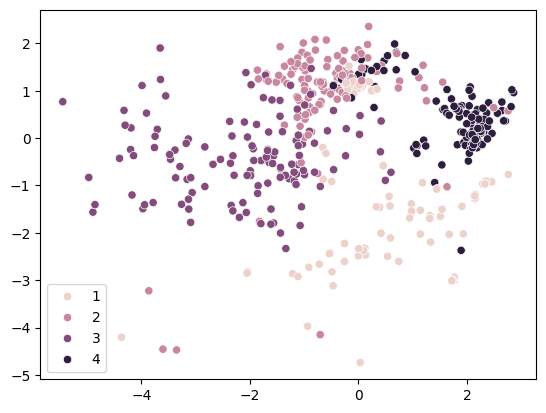

In [24]:
X_test_lda = lda.transform(X_test)
sns.scatterplot(
    x=X_test_lda[:, 0],
    y=X_test_lda[:, 1],
    hue=Y_test,
)

In [25]:
pipeline = make_pipeline(
    LinearDiscriminantAnalysis(n_components=3),
    DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=40),
)
pipeline

Pipeline(steps=[('lineardiscriminantanalysis',
                 LinearDiscriminantAnalysis(n_components=3)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_split=40))])

In [26]:
pipeline.fit(X_train, Y_train)
Y_pred_pipeline = pipeline.predict(X_test)
(Y_pred_pipeline == Y_test).mean()

0.8349900596421471